In [2]:
import numpy as np
import gc
import copy
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
import os
import pickle
import matplotlib
import seaborn as sns

from feat_loading import *

In [5]:
gc.collect()
app_train = load_dataframe("train_all.csv")
app_test = load_dataframe("test_all.csv")
app_train, app_test = load_extra_feats_post(app_train, app_test)
to_del = del_single_variance_and_nan_too_much(app_train)
app_test = app_test.drop(to_del, axis=1)


BURO_CREDIT_SUM_LIMIT_DEBT_RATIO_VAR
ACTIVE_CREDIT_SUM_LIMIT_DEBT_RATIO_VAR
ACTIVE_MAX_OVERDUE_RATIO_VAR
CLOSED_CREDIT_SUM_LIMIT_DEBT_RATIO_MIN
CLOSED_CREDIT_SUM_LIMIT_DEBT_RATIO_MAX
CLOSED_CREDIT_SUM_LIMIT_DEBT_RATIO_MEAN
CLOSED_CREDIT_SUM_LIMIT_DEBT_RATIO_VAR
CLOSED_CREDIT_SUM_LIMIT_OVERDUE_RATIO_MIN
CLOSED_CREDIT_SUM_LIMIT_OVERDUE_RATIO_MAX
CLOSED_CREDIT_SUM_LIMIT_OVERDUE_RATIO_MEAN
CLOSED_CREDIT_SUM_LIMIT_OVERDUE_RATIO_VAR
PREV_INTREST_RATE_RATIO_MAX
PREV_INTREST_RATE_RATIO_MEAN
PREV_INTREST_RATE_RATIO_VAR
APPROVED_INTREST_RATE_RATIO_MAX
APPROVED_INTREST_RATE_RATIO_MEAN
APPROVED_INTREST_RATE_RATIO_VAR
REFUSED_APP_DURATION_MAX
REFUSED_APP_DURATION_MEAN
REFUSED_APP_PAY_DURATION_MAX
REFUSED_APP_PAY_DURATION_MEAN
REFUSED_INTREST_RATE_RATIO_MAX
REFUSED_INTREST_RATE_RATIO_MEAN
REFUSED_INTREST_RATE_RATIO_VAR
24 columns need to be dropped


In [6]:
for alg in ["RF", "ET", "CB", "MLP"]:
    oof = load_dataframe(alg + "_oof.csv")
    app_train = app_train.merge(right=oof.reset_index(), how='left', on='SK_ID_CURR')
    if "index" in app_train.columns:
        app_train = app_train.drop("index", axis=1)
    del oof
    gc.collect()
    
    t_oof = load_dataframe(alg + "_test.csv")
    app_test = app_test.merge(right=t_oof.reset_index(), how='left', on='SK_ID_CURR')
    if "index" in app_test.columns:
        app_test = app_test.drop("index", axis=1)
    del t_oof
    gc.collect()

In [18]:
test = load_dataframe("improved_lgb_all_tables21.csv")
test.columns = ['SK_ID_CURR', "LGB"]

lgboof = load_dataframe("LGB_oof.csv")

app_train = app_train.merge(right=lgboof.reset_index(), how='left', on='SK_ID_CURR')
if "index" in app_train.columns:
    app_train = app_train.drop("index", axis=1)
del lgboof
gc.collect()

app_test = app_test.merge(right=test.reset_index(), how='left', on='SK_ID_CURR')
if "index" in app_test.columns:
    app_test = app_test.drop("index", axis=1)
del test
gc.collect()


49

In [24]:
app_train = app_train.drop("index_x", axis=1)
app_test = app_test.drop("index_x", axis=1)
app_train = app_train.drop("index_y", axis=1)
app_test = app_test.drop("index_y", axis=1)

In [7]:
with open("jjsmd.bin", "rb") as f:
    fi_past = pickle.load(f)
    
bad_features = fi_past.sort_values("importance", ascending=False)["feature"][350:].tolist()
app_train = app_train.drop(columns=bad_features)
app_test = app_test.drop(columns=bad_features)

In [25]:
app_train.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,birth_div_reg,ANN_LENGTH_EMPLOYED_RATIO,age_finish,ANN_LENGTH_AGE_RATIO,NEW_DOC_IND_KURT,RF,ET,CB,MLP,LGB
0,100002,202500.0,406597.5,24700.5,0.018801,-9461,-637.0,-3648.0,-2120,NaN,...,2.593476,-0.025842,27.292307,3.972353e-07,20.0,0.133470,0.111521,0.551934,1.338416e-03,0.204268
1,100003,270000.0,1293502.5,35698.5,0.003541,-16765,-1188.0,-1186.0,-291,NaN,...,14.135750,-0.030500,48.951014,4.934460e-07,20.0,0.035103,0.041009,0.075232,8.947332e-99,0.012681
2,100004,67500.0,135000.0,6750.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,...,4.470892,-0.088889,53.847489,2.397464e-07,0.0,0.059222,0.063006,0.144619,1.733422e-01,0.041665
3,100006,135000.0,312682.5,29686.5,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,...,1.932777,-0.003466,52.946228,1.265326e-07,20.0,0.067127,0.100749,0.102485,7.958846e-02,0.030604
4,100007,121500.0,513000.0,21865.5,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,...,4.623521,-0.007723,56.563354,2.687404e-07,20.0,0.064339,0.075361,0.297315,4.917194e-48,0.071715


In [26]:
import modelling
importlib.reload(modelling)

gc.collect()
new_params = dict(
        boosting_type="gbdt", n_estimators=10000, objective='binary',
        learning_rate=0.01, n_jobs=5, random_state=50,
        subsample=0.81, reg_alpha=0.1, reg_lambda=0.85, min_child_samples=40,
        max_depth=8, colsample_bytree=0.8, num_leaves=45
    )
cat_feats = [
    'NAME_CONTRACT_TYPE', 
              'FLAG_OWN_CAR', 
             'FLAG_OWN_REALTY']
submission, fi, metrics = modelling.model(app_train, app_test, 
#                                           cat_feats, 
                                          parallel=5, lgbm_params=new_params)
print('Baseline metrics')
print(metrics)
submission.to_csv('stacked.csv', index = False)

Training until validation scores don't improve for 400 rounds.
[200]	train's auc: 0.807399	train's binary_logloss: 0.231366	valid's auc: 0.793059	valid's binary_logloss: 0.234862
[400]	train's auc: 0.822377	train's binary_logloss: 0.225283	valid's auc: 0.792781	valid's binary_logloss: 0.233673
[600]	train's auc: 0.833267	train's binary_logloss: 0.221087	valid's auc: 0.792065	valid's binary_logloss: 0.233872
Early stopping, best iteration is:
[219]	train's auc: 0.808908	train's binary_logloss: 0.230567	valid's auc: 0.793216	valid's binary_logloss: 0.2345
Training until validation scores don't improve for 400 rounds.
[200]	train's auc: 0.807943	train's binary_logloss: 0.230955	valid's auc: 0.791994	valid's binary_logloss: 0.236293
[400]	train's auc: 0.822573	train's binary_logloss: 0.224935	valid's auc: 0.792132	valid's binary_logloss: 0.235131
[600]	train's auc: 0.832753	train's binary_logloss: 0.220789	valid's auc: 0.791846	valid's binary_logloss: 0.235199
[800]	train's auc: 0.842757	t

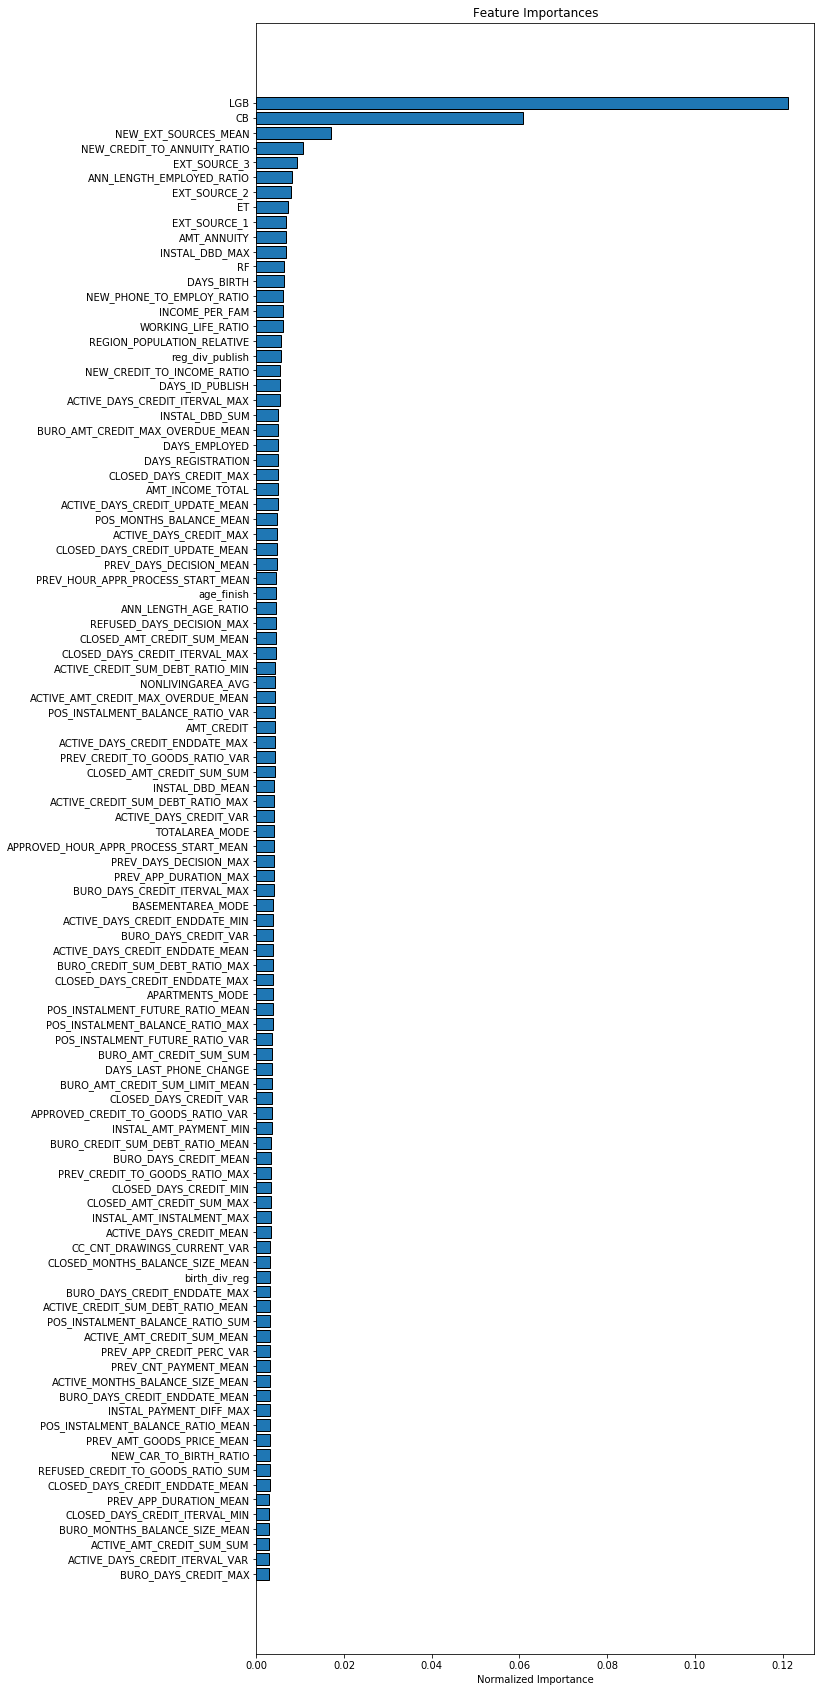

[]


In [27]:
importlib.reload(modelling)
fi_sorted = modelling.plot_feature_importances(fi, 100)
# display(fi_sorted[fi_sorted["feature"]=="ORG_XNA_no_Pensioner"])
print(fi_sorted[fi_sorted["importance"]==0]["feature"].tolist())

In [24]:
oof_path = "oof"

test = load_dataframe(os.path.join(oof_path, "improved_lgb_all_tables21.csv"))
test.columns = ['SK_ID_CURR', "LGB"]

oof = load_dataframe(os.path.join(oof_path, "LGB_oof.csv"))


In [ ]:
app_test = load_dataframe("test_all.csv")
app_train = load_dataframe("train_all.csv")

In [25]:
for file in os.listdir(oof_path):
    if not file.endswith(".csv"):
        continue
    df = load_dataframe(os.path.join(oof_path, file))
    if file.endswith("oof.csv") and "LGB" not in file:
        oof = oof.merge(right=df.reset_index(), how='left', on='SK_ID_CURR')
        oof = oof.drop("index", axis=1)
    elif file.endswith("test.csv"):
        test = test.merge(right=df.reset_index(), how='left', on='SK_ID_CURR')
        test = test.drop("index", axis=1)

In [36]:
X = oof.drop(['SK_ID_CURR', "ET"], axis=1)
y = app_train["TARGET"]
tX = test.drop(['SK_ID_CURR', "ET",
                "TARGET"
               ], axis=1)
lr = LogisticRegressionCV()
lr.fit(X, y)
test['TARGET'] = lr.predict_proba(tX)[:,1]
test[['SK_ID_CURR', 'TARGET']].to_csv('stacking_submission4.csv', index=False, float_format='%.8f')

In [34]:
X = oof.drop(['SK_ID_CURR'], axis=1)
y = app_train["TARGET"]
tX = test.drop(['SK_ID_CURR', 
                "TARGET"
               ], axis=1)
tc = DecisionTreeClassifier()
tc.fit(X, y)
test['TARGET'] = tc.predict_proba(tX)[:,1]
test[['SK_ID_CURR', 'TARGET']].to_csv('stacking_submission3.csv', index=False, float_format='%.8f')

In [ ]:
from skopt import BayesSearchCV

bayes_tuner = BayesSearchCV(
    LogisticRegressionCV(scoring="auc", random_state=200),
    dict(
        Cs=(1e-5, 100), 
        fit_intercept=[True, False], 
        cv='warn', 
        tol=(1e-7, 1e+3, 'log-uniform'), 
        max_iter=(70, 1000), 
        refit=[True, False], 
        multi_class='warn',
    )
    n_iter = 500
)

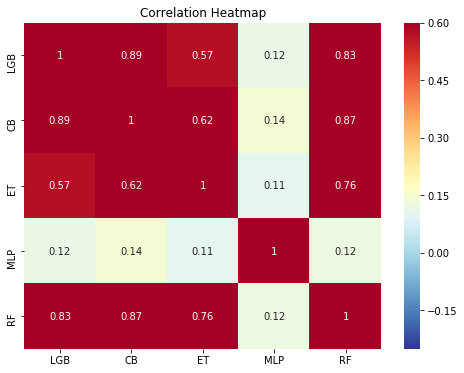

In [49]:
data_corrs = oof.drop(['SK_ID_CURR'], axis=1).corr()
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');